# Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pickle as pkl
from PIL import Image
import torch
from torch.backends import cudnn
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
from torchvision import transforms
from skimage import io, transform
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
import sys

In [2]:
sys.path.append('/WorkSpace/PrivacyGAN/common/')
sys.path.append('/WorkSpace/PrivacyGAN/models/')

In [3]:
from pix2pix import define_G
import utility as utils

# Import Data

In [4]:
train_path, valid_path, \
    y_cls_train, y_cls_valid, \
    y_cxt_train, y_cxt_valid = pkl.load(open('../checkpoints/nico/dataset_animal.pkl', 'rb'))

# Environment Variables

In [5]:
BATCH_SIZE = 16
MULTISCALE = False
N_CPU = 8
IMAGE_DIM = 128

# Load Dataset

In [6]:
cls_encoder = LabelEncoder()
y_cls_train = cls_encoder.fit_transform(y_cls_train)
y_cls_valid = cls_encoder.transform(y_cls_valid)
cxt_encoder = LabelEncoder()
y_cxt_train = cxt_encoder.fit_transform(y_cxt_train)

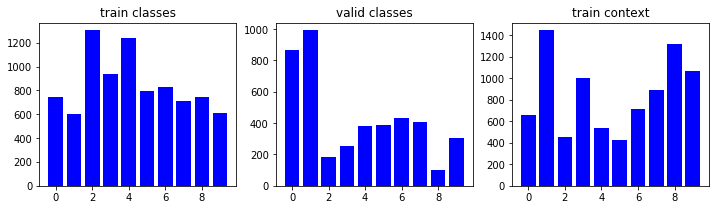

In [7]:
fig = plt.figure(figsize=(12,3))
ax1 = plt.subplot(131)
ax1.bar(np.unique(y_cls_train), np.bincount(y_cls_train), color='b')
ax1.set_title('train classes')
ax1 = plt.subplot(132)
ax1.bar(np.unique(y_cls_train), np.bincount(y_cls_valid), color='b')
ax1.set_title('valid classes')
ax1 = plt.subplot(133)
ax1.bar(np.unique(y_cxt_train), np.bincount(y_cxt_train), color='b')
ax1.set_title('train context')
plt.show()

In [8]:
w_cls = compute_class_weight('balanced', np.unique(y_cls_train), y_cls_train)
w_cxt = compute_class_weight('balanced', np.unique(y_cxt_train), y_cxt_train)

In [9]:
y_cls_train = utils.to_categorical(y_cls_train)
y_cls_valid = utils.to_categorical(y_cls_valid)
y_cxt_train = utils.to_categorical(y_cxt_train)

NUM_CLS = y_cls_train.shape[1]
NUM_CXT = y_cxt_train.shape[1]
y_cls_train.shape, y_cls_valid.shape, y_cxt_train.shape

((8511, 10), (4309, 10), (8511, 10))

In [10]:
class NICODataset(Dataset):
    def __init__(self, path, label_0, label_1, transform=None):
        assert len(path) == len(label_0) and len(path) == len(label_1)
        self.path = path
        self.label_0 = label_0
        self.label_1 = label_1
        self.transform = transform
        
    def __len__(self):
        return len(self.path)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        image_path = self.path[idx]
        image = Image.open(image_path)
        image = image.resize((IMAGE_DIM, IMAGE_DIM))
        image = np.array(image)
        sample = {
            'image': image, 
            'cls': self.label_0[idx],
            'cxt': self.label_1[idx]
        }
        
        if self.transform:
            sample = self.transform(sample)

        return sample
    
    def collate_fn(self, batch):
        imgs, cls, cxts = [], [], []
        for elem in batch:
            imgs.append(elem['image'])
            cls.append(elem['cls'])
            cxts.append(elem['cxt'])
        imgs = torch.stack(imgs)
        cls = torch.stack(cls)
        cxts = torch.stack(cxts)
        return {
            'image': imgs, 
            'cls': cls, 
            'cxt': cxts
        }
    
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, cls, cxt = sample['image'], sample['cls'], sample['cxt']
        image = image.transpose((2, 0, 1))
        return {
            'image': torch.from_numpy(image).float().div(255),
            'cls': torch.from_numpy(cls),
            'cxt': torch.from_numpy(cxt)
               }

In [11]:
train_dataset = NICODataset(train_path, y_cls_train, y_cxt_train, transform=transforms.Compose([ToTensor()]))
valid_dataset = NICODataset(valid_path, y_cls_valid, y_cls_valid, transform=transforms.Compose([ToTensor()]))

0 2898 torch.Size([3, 128, 128])
1 8105 torch.Size([3, 128, 128])
2 3962 torch.Size([3, 128, 128])
3 7502 torch.Size([3, 128, 128])


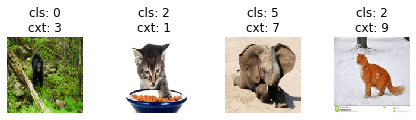

0 1608 torch.Size([3, 128, 128])
1 1519 torch.Size([3, 128, 128])
2 3060 torch.Size([3, 128, 128])
3 4208 torch.Size([3, 128, 128])


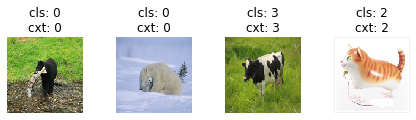

In [12]:
fig = plt.figure()

for data in [train_dataset, valid_dataset]:
    for i in range(len(data)):
        j = np.random.randint(0, len(data))
        sample = data[j]

        print(i, j, sample['image'].shape)

        ax = plt.subplot(1, 4, i + 1)
        plt.tight_layout()
        ax.set_title('cls: {}\ncxt: {}'.format(np.argmax([sample['cls'].numpy()], axis=1)[0], 
                                               np.argmax([sample['cxt'].numpy()], axis=1)[0]))
        ax.axis('off')
        plt.imshow(sample['image'].numpy().transpose(1, 2, 0))

        if i == 3:
            plt.show()
            break

In [13]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=1, 
                          collate_fn=train_dataset.collate_fn)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=1, 
                          collate_fn=train_dataset.collate_fn)

# Training Setup

In [14]:
from torchvision.models import resnet18 as Net
from torchsummary import torchsummary

In [15]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
cudnn.benchmark = True
use_cuda

True

In [16]:
net_g = define_G(3, 3, 64, 'batch', False, 'normal', 0.02, gpu_id=device)
 
model_0 = Net(num_classes=NUM_CLS).to(device)
model_1 = Net(num_classes=NUM_CXT).to(device)

initialize network with normal


In [17]:
optimizer_g = torch.optim.Adam(net_g.parameters(), lr=0.001)
optimizer_0 = torch.optim.Adam(model_0.parameters(), lr=0.00001)
optimizer_1 = torch.optim.Adam(model_1.parameters(), lr=0.00001)

model_0.apply(utils.weights_init_normal)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [18]:
model_1.apply(utils.weights_init_normal)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [19]:
clsBCE = torch.nn.BCEWithLogitsLoss(pos_weight=torch.Tensor(w_cls)).to(device)
cxtBCE = torch.nn.BCEWithLogitsLoss(pos_weight=torch.Tensor(w_cxt)).to(device)
_BCE = torch.nn.BCEWithLogitsLoss().to(device)

In [20]:
EPOCHS = 100
IMAGE_SIZE=128
EPSILON = -np.log(1/NUM_CXT)
ALPHA = 1
ACC_BEST = 0

In [21]:
import warnings
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
warnings.simplefilter("ignore")
h_epochs = []
h_train_losses_g = []
h_valid_losses_0 = []
h_train_losses_0 = []
h_valid_acc_0 = []
h_train_acc_0 = []
h_train_losses_1 = []
h_train_acc_1 = []

epoch 	 encd_train 	 0_valid 	 0_train 	 1_train


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


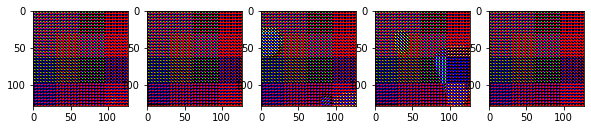

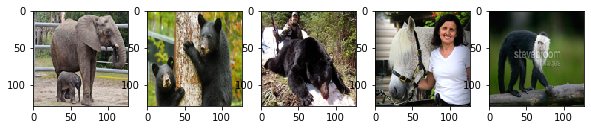

Saving Best...
0 	 -1.6685 	 0.3290(0.12) 	 0.3161(0.17) 	 0.3205(0.20)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


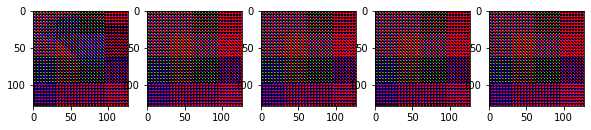

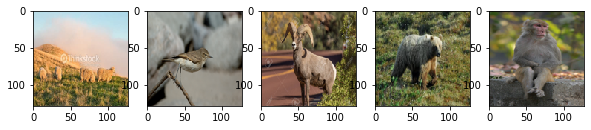

Saving Best...
1 	 -1.7040 	 0.3270(0.13) 	 0.3081(0.19) 	 0.2936(0.29)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


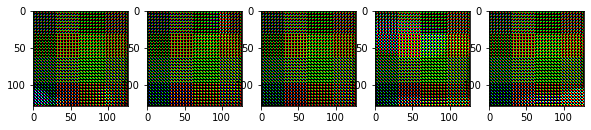

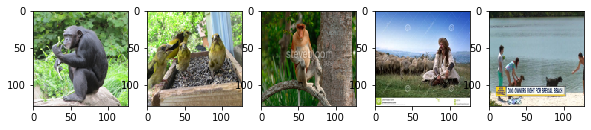

Saving Best...
2 	 -1.7361 	 0.3221(0.17) 	 0.2847(0.22) 	 0.2852(0.31)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


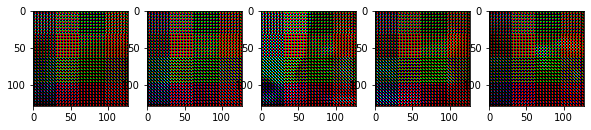

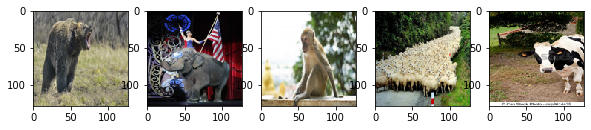

3 	 -1.7713 	 0.3172(0.16) 	 0.2965(0.24) 	 0.2390(0.35)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


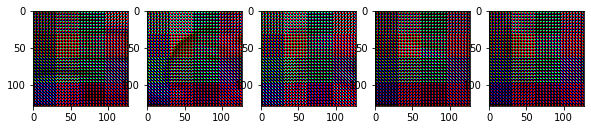

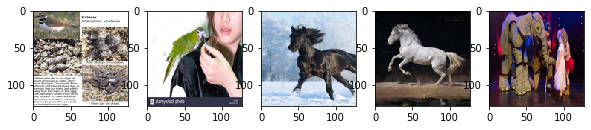

Saving Best...
4 	 -1.7401 	 0.3075(0.21) 	 0.3034(0.27) 	 0.2644(0.37)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


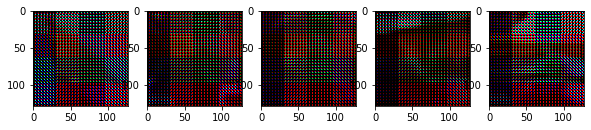

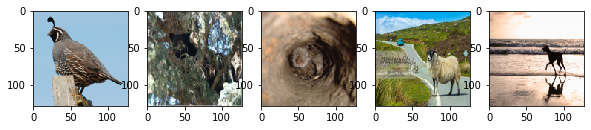

5 	 -1.7972 	 0.3083(0.21) 	 0.2576(0.31) 	 0.2523(0.39)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


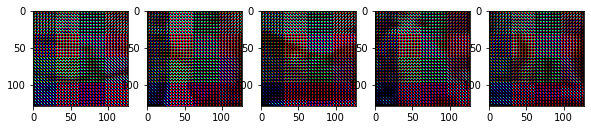

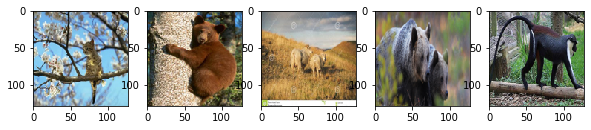

Saving Best...
6 	 -1.8035 	 0.3056(0.24) 	 0.2425(0.33) 	 0.2626(0.40)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


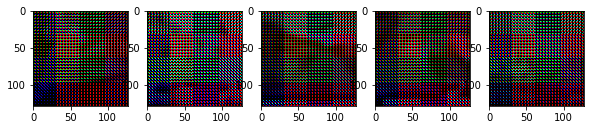

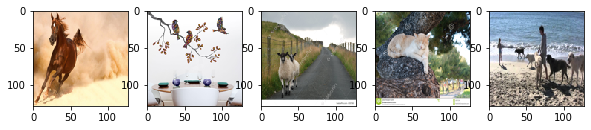

Saving Best...
7 	 -1.8025 	 0.2976(0.29) 	 0.2800(0.35) 	 0.2259(0.42)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


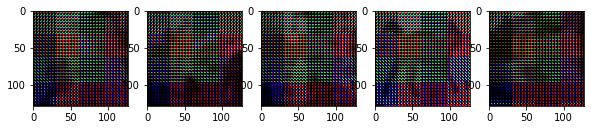

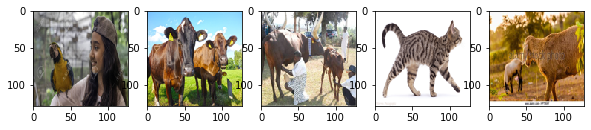

8 	 -1.8347 	 0.3056(0.27) 	 0.1964(0.38) 	 0.2774(0.44)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


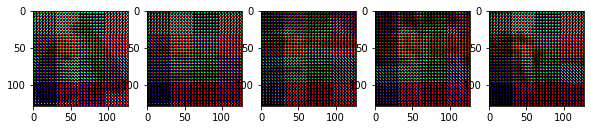

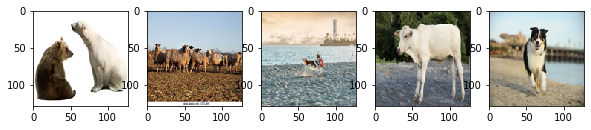

Saving Best...
9 	 -1.8088 	 0.2997(0.29) 	 0.2789(0.40) 	 0.2245(0.47)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


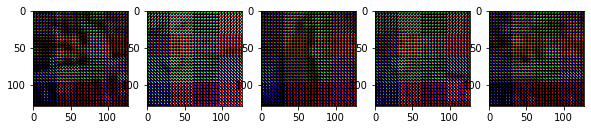

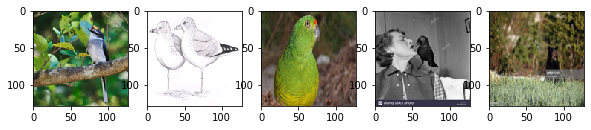

Saving Best...
10 	 -1.9210 	 0.2984(0.30) 	 0.2089(0.43) 	 0.1791(0.49)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


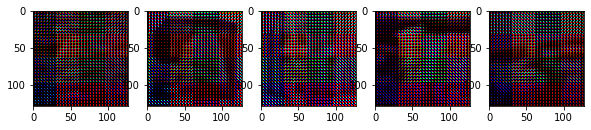

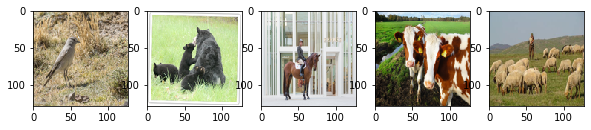

Saving Best...
11 	 -1.7981 	 0.2906(0.32) 	 0.3144(0.46) 	 0.2027(0.52)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


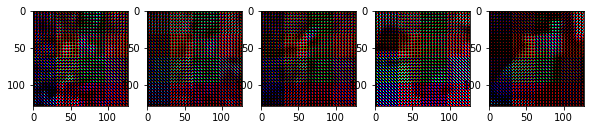

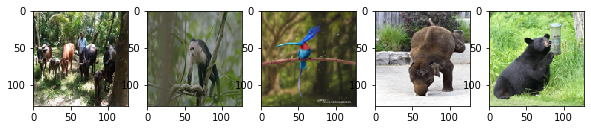

Saving Best...
12 	 -1.8641 	 0.2920(0.32) 	 0.2432(0.49) 	 0.2095(0.55)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


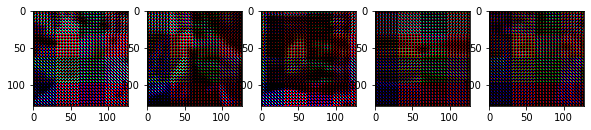

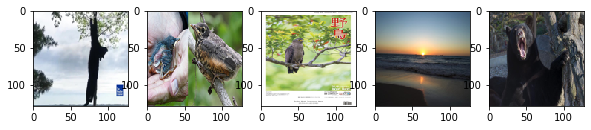

13 	 -1.8154 	 0.3018(0.31) 	 0.2457(0.54) 	 0.2706(0.59)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


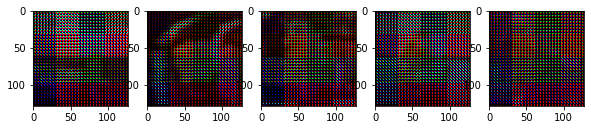

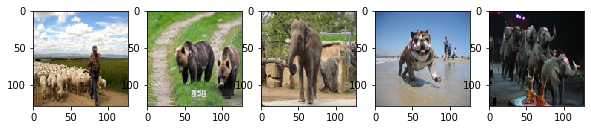

14 	 -1.9109 	 0.3017(0.31) 	 0.1908(0.58) 	 0.2210(0.62)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


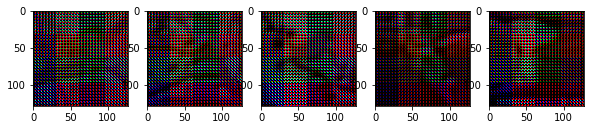

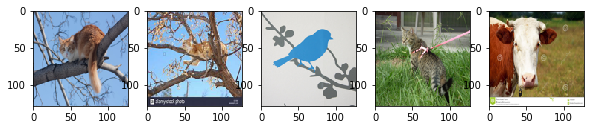

15 	 -1.8562 	 0.3062(0.31) 	 0.2422(0.63) 	 0.2373(0.67)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


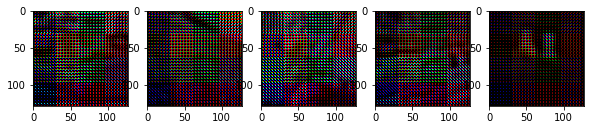

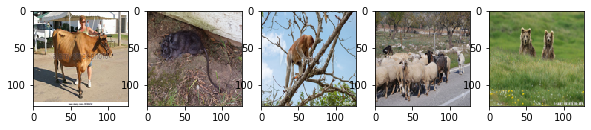

Saving Best...
16 	 -2.0211 	 0.3045(0.33) 	 0.1323(0.68) 	 0.1712(0.71)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


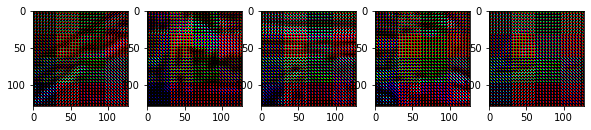

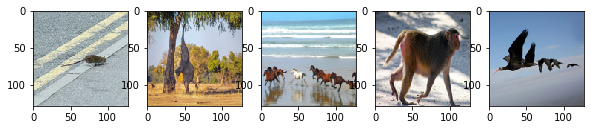

17 	 -2.0962 	 0.3179(0.31) 	 0.1337(0.74) 	 0.0843(0.76)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


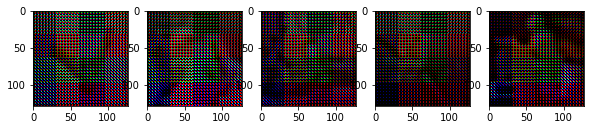

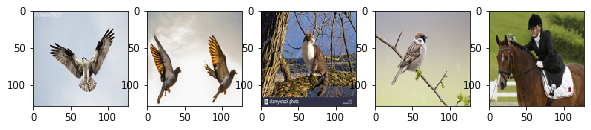

18 	 -2.0840 	 0.3299(0.30) 	 0.1074(0.79) 	 0.1321(0.78)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


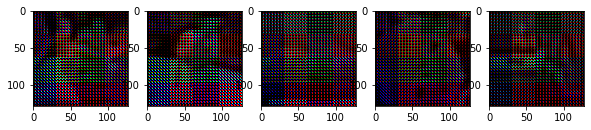

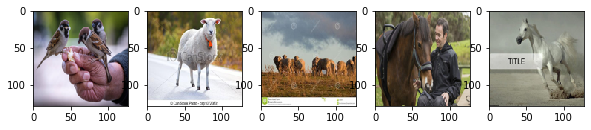

19 	 -2.0913 	 0.3564(0.27) 	 0.1175(0.83) 	 0.1103(0.84)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


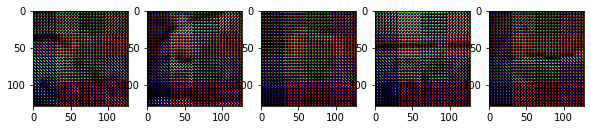

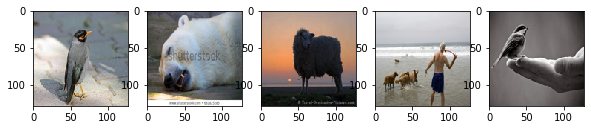

20 	 -2.1619 	 0.3585(0.29) 	 0.0841(0.87) 	 0.0719(0.87)


 52%|█████▏    | 277/532 [02:20<02:10,  1.96it/s]

In [ ]:
print('epoch \t encd_train \t 0_valid \t 0_train \t 1_train')
for epoch in range(EPOCHS):
    model_0.train()
    model_1.train()
    net_g.train()
    
    correct_cls = 0 
    total_cls = 0
    correct_cxt = 0
    total_cxt = 0
    for batch_i, batch in tqdm(enumerate(train_loader), total=len(train_loader), leave=False):
        
        # Update Model 0 Discriminator
        optimizer_0.zero_grad()

        imgs = batch['image']
        cls = batch['cls'].to(device)
        cxt = batch['cxt'].to(device)
        batches_done = len(train_loader) * epoch + batch_i
        imgs = Variable(imgs.to(device))
        
        g_imgs = net_g(imgs)
        cls_ = model_0(g_imgs)
        loss_0_train = clsBCE(cls_, cls)
        loss_0_train.backward()
        optimizer_0.step()
            
        _, predicted = torch.max(cls_, 1)
        _, actuals = torch.max(cls, 1)
        correct_cls += (predicted == actuals).sum().item()
        total_cls += cls.shape[0]
        
        # Update Model 1 Discriminator
        optimizer_1.zero_grad()
        
        g_imgs = net_g(imgs)
        cxt_ = model_1(g_imgs)
        loss_1_train = cxtBCE(cxt_, cxt)
        loss_1_train.backward()
        optimizer_1.step()
            
        _, predicted = torch.max(cxt_, 1)
        _, actuals = torch.max(cxt, 1)
        correct_cxt += (predicted == actuals).sum().item()
        total_cxt += cls.shape[0]
        
        # Update Generator
        optimizer_g.zero_grad()
        
        imgs = Variable(imgs.to(device))
        g_imgs = net_g(imgs)
        
        cls_ = model_0(g_imgs)
        cxt_ = model_1(g_imgs)
        loss_0 = clsBCE(cls_, cls)
        loss_1 = cxtBCE(cxt_, cxt)
        loss_g_train = loss_0 + ALPHA * (loss_1 - EPSILON)
        loss_g_train.backward()
        optimizer_g.step()
        
    h_train_acc_0.append(correct_cls/total_cls)
    h_train_acc_1.append(correct_cxt/total_cxt)

    if epoch % 1 == 0:        
        vloss_0 = 0
        bcount = 0
        
        correct = 0
        total = 0
        
        for batch_i, batch in tqdm(enumerate(valid_loader), total=len(valid_loader), leave=False):
            imgs = batch['image']
            cls = batch['cls'].to(device)
            cxt = batch['cxt'].to(device)
                
            imgs = Variable(imgs.to(device))        
            g_imgs = net_g(imgs)
            cls_ = model_0(g_imgs)
            cxt_ = model_1(g_imgs)
            loss_0 = _BCE(cls_, cls)
            
            _, predicted = torch.max(cls_, 1)
            _, actuals = torch.max(cls, 1)
            correct += (predicted == actuals).sum().item()
            total += cls.shape[0]
            
            bcount += 1 
            vloss_0 += loss_0.item()
            
        h_valid_acc_0.append(correct/total)

        g_imgs = g_imgs.cpu().detach().numpy()
        fig = plt.figure(figsize=(16, 6))
        count = 0
        for img in g_imgs.transpose(0, 2, 3, 1):
            ax = fig.add_subplot(181+count)
            count += 1
            plt.imshow(img)
            if count >= 8:
                break
        plt.show()

        imgs = imgs.cpu().detach().numpy()
        fig = plt.figure(figsize=(16, 6))
        count = 0
        for img in imgs.transpose(0, 2, 3, 1):
            ax = fig.add_subplot(181+count)
            count += 1
            plt.imshow(img)
            if count >= 8:
                break
        plt.show()

        
        if h_valid_acc_0[-1] > ACC_BEST:
            print('Saving Best...')
            ACC_BEST = h_valid_acc_0[-1]
            torch.save(net_g, 'nico_generator_best.pkl')
                            
        print('{} \t {:.4f} \t {:.4f}({:.2f}) \t {:.4f}({:.2f}) \t {:.4f}({:.2f})'.format(
            epoch, loss_g_train.item(),
            vloss_0/bcount, h_valid_acc_0[-1],
            loss_0_train.item(), h_train_acc_0[-1],
            loss_1_train.item(), h_train_acc_1[-1]
        ))

        h_epochs.append(epoch)
        h_train_losses_g.append(loss_g_train.item())
        h_valid_losses_0.append(vloss_0/bcount)
        h_train_losses_0.append(loss_0_train.item())
        h_train_losses_1.append(loss_1_train.item())

# Encoding Check

In [21]:
net_g = torch.load('./nico_generator_best.pkl')

In [22]:
print('epoch \t 0_valid \t 0_train')
for epoch in range(EPOCHS):
    model_0.train()
    
    correct = 0 
    total = 0
    for batch_i, batch in tqdm(enumerate(train_loader), total=len(train_loader), leave=False):
        imgs = batch['image']
        cls = batch['cls'].to(device)
        imgs = Variable(imgs.to(device))
        
        g_imgs = net_g(imgs)
        cls_ = model_0(g_imgs)
        loss_0_train = _BCE(cls_, cls)
        optimizer_0.zero_grad()
        loss_0_train.backward()
        optimizer_0.step()
            
        _, predicted = torch.max(cls_, 1)
        _, actuals = torch.max(cls, 1)
        correct += (predicted == actuals).sum().item()
        total += cls.shape[0]
        
    h_train_acc_0.append(correct/total)

    model_0.eval()
        
    if epoch % 1 == 0:        
        model_0.eval()
        
        vloss_0 = 0
        bcount = 0
        
        correct = 0
        total = 0
        
        batch_show = np.random.randint(0, len(valid_loader))
        for batch_i, batch in tqdm(enumerate(valid_loader), total=len(valid_loader), leave=False):
            imgs = batch['image']
            cls = batch['cls'].to(device)
                
            imgs = Variable(imgs.to(device))        
            g_imgs = net_g(imgs)
            cls_ = model_0(g_imgs)
            loss_0 = _BCE(cls_, cls)
            
            _, predicted = torch.max(cls_, 1)
            _, actuals = torch.max(cls, 1)
            correct += (predicted == actuals).sum().item()
            total += cls.shape[0]
            
            bcount += 1 
            vloss_0 += loss_0.item()

        h_valid_acc_0.append(correct/total)
                            
        print('{} \t {:.4f}({:.2f}) \t {:.4f}({:.2f})'.format(
            epoch, 
            vloss_0/bcount, h_valid_acc_0[-1],
            loss_0_train.item(), h_train_acc_0[-1],
        ))

        h_epochs.append(epoch)
        h_valid_losses_0.append(vloss_0/bcount)
        h_train_losses_0.append(loss_0_train.item())

epoch 	 0_valid 	 0_train


0 	 0.3042(0.23) 	 0.3192(0.24)


1 	 0.2882(0.30) 	 0.2540(0.36)


2 	 0.2854(0.32) 	 0.2506(0.43)


3 	 0.2785(0.36) 	 0.2702(0.47)


4 	 0.2780(0.36) 	 0.2052(0.54)


5 	 0.2813(0.37) 	 0.2304(0.60)


6 	 0.3034(0.32) 	 0.1535(0.68)


7 	 0.2988(0.35) 	 0.1497(0.75)


8 	 0.2990(0.35) 	 0.1089(0.82)


9 	 0.3124(0.35) 	 0.0948(0.87)


10 	 0.3312(0.34) 	 0.0797(0.91)


11 	 0.3538(0.32) 	 0.0930(0.92)


12 	 0.3438(0.34) 	 0.0627(0.95)


13 	 0.3714(0.30) 	 0.0689(0.95)


14 	 0.3683(0.32) 	 0.0304(0.97)


15 	 0.3685(0.33) 	 0.0507(0.97)


16 	 0.3823(0.32) 	 0.0200(0.97)


17 	 0.4046(0.31) 	 0.0168(0.98)


18 	 0.3974(0.31) 	 0.0156(0.98)


19 	 0.4042(0.32) 	 0.0108(0.98)


20 	 0.4082(0.32) 	 0.0120(0.98)


21 	 0.4166(0.32) 	 0.0250(0.98)


22 	 0.4034(0.34) 	 0.0076(0.98)


23 	 0.4086(0.33) 	 0.0175(0.99)


24 	 0.4264(0.32) 	 0.0369(0.99)


25 	 0.4346(0.32) 	 0.0289(0.99)


26 	 0.4457(0.31) 	 0.0076(0.99)


27 	 0.4490(0.32) 	 0.0094(0.99)


 12%|█▏        | 62/532 [00:16<01:53,  4.14it/s]

KeyboardInterrupt: 

In [21]:
print('epoch \t 0_valid \t 0_train')
for epoch in range(EPOCHS):
    model_0.train()
    
    correct = 0 
    total = 0
    for batch_i, batch in tqdm(enumerate(train_loader), total=len(train_loader), leave=False):
        imgs = batch['image']
        cls = batch['cls'].to(device)
        imgs = Variable(imgs.to(device))
        
        g_imgs = imgs
        cls_ = model_0(g_imgs)
        loss_0_train = _BCE(cls_, cls)
        optimizer_0.zero_grad()
        loss_0_train.backward()
        optimizer_0.step()
            
        _, predicted = torch.max(cls_, 1)
        _, actuals = torch.max(cls, 1)
        correct += (predicted == actuals).sum().item()
        total += cls.shape[0]
        
    h_train_acc_0.append(correct/total)

    model_0.eval()
        
    if epoch % 1 == 0:        
        model_0.eval()
        
        vloss_0 = 0
        bcount = 0
        
        correct = 0
        total = 0
        
        batch_show = np.random.randint(0, len(valid_loader))
        for batch_i, batch in tqdm(enumerate(valid_loader), total=len(valid_loader), leave=False):
            imgs = batch['image']
            cls = batch['cls'].to(device)
                
            imgs = Variable(imgs.to(device))        
            g_imgs = imgs
            cls_ = model_0(g_imgs)
            loss_0 = _BCE(cls_, cls)
            
            _, predicted = torch.max(cls_, 1)
            _, actuals = torch.max(cls, 1)
            correct += (predicted == actuals).sum().item()
            total += cls.shape[0]
            
            bcount += 1 
            vloss_0 += loss_0.item()

        h_valid_acc_0.append(correct/total)
                            
        print('{} \t {:.4f}({:.2f}) \t {:.4f}({:.2f})'.format(
            epoch, 
            vloss_0/bcount, h_valid_acc_0[-1],
            loss_0_train.item(), h_train_acc_0[-1],
        ))

        h_epochs.append(epoch)
        h_valid_losses_0.append(vloss_0/bcount)
        h_train_losses_0.append(loss_0_train.item())

epoch 	 0_valid 	 0_train


0 	 0.3406(0.20) 	 0.3111(0.25)


1 	 0.3065(0.31) 	 0.2953(0.34)


2 	 0.2832(0.35) 	 0.2000(0.40)


3 	 0.3035(0.34) 	 0.2575(0.46)


4 	 0.2829(0.37) 	 0.2342(0.52)


5 	 0.3516(0.30) 	 0.1587(0.58)


6 	 0.2872(0.43) 	 0.1317(0.66)


7 	 0.2701(0.48) 	 0.1222(0.74)


8 	 0.3637(0.39) 	 0.1010(0.82)


9 	 0.3387(0.44) 	 0.0685(0.88)


10 	 0.3951(0.41) 	 0.0110(0.92)


11 	 0.4641(0.37) 	 0.0457(0.94)


12 	 0.4564(0.40) 	 0.0462(0.94)


13 	 0.4766(0.38) 	 0.0631(0.95)


14 	 0.4490(0.40) 	 0.0395(0.96)


15 	 0.4943(0.38) 	 0.0263(0.97)


16 	 0.5147(0.38) 	 0.0069(0.96)


17 	 0.4933(0.38) 	 0.0715(0.97)


18 	 0.5014(0.38) 	 0.0092(0.96)


19 	 0.5060(0.38) 	 0.0086(0.97)


20 	 0.4954(0.38) 	 0.0062(0.96)


21 	 0.5405(0.35) 	 0.0205(0.97)


22 	 0.5575(0.36) 	 0.0773(0.98)


23 	 0.6095(0.32) 	 0.0422(0.98)


24 	 0.5541(0.36) 	 0.0053(0.98)


25 	 0.5614(0.38) 	 0.0153(0.98)


26 	 0.5243(0.37) 	 0.0237(0.98)


27 	 0.5496(0.37) 	 0.0229(0.98)


28 	 0.5622(0.38) 	 0.0085(0.98)


29 	 0.4866(0.43) 	 0.0230(0.98)


30 	 0.5739(0.37) 	 0.0095(0.98)


31 	 0.5552(0.37) 	 0.0084(0.98)


32 	 0.5469(0.38) 	 0.0223(0.99)


33 	 0.5497(0.38) 	 0.0086(0.98)


34 	 0.5618(0.37) 	 0.0056(0.98)


35 	 0.5657(0.38) 	 0.0063(0.98)


36 	 0.5551(0.39) 	 0.0802(0.98)


37 	 0.5412(0.40) 	 0.0229(0.99)


38 	 0.5851(0.38) 	 0.0087(0.99)


39 	 0.6030(0.38) 	 0.0602(0.98)


40 	 0.5513(0.39) 	 0.0030(0.98)


41 	 0.6196(0.34) 	 0.0054(0.99)


42 	 0.6009(0.38) 	 0.0047(0.99)


43 	 0.5998(0.38) 	 0.0156(0.98)


44 	 0.5309(0.41) 	 0.0040(0.98)


45 	 0.6126(0.38) 	 0.0020(0.99)


46 	 0.6068(0.36) 	 0.0079(0.99)


47 	 0.5892(0.38) 	 0.0103(0.99)


48 	 0.6124(0.36) 	 0.0008(0.99)


49 	 0.5859(0.39) 	 0.0068(0.98)


50 	 0.5542(0.39) 	 0.0023(0.99)


51 	 0.5371(0.42) 	 0.0003(1.00)


52 	 0.6398(0.36) 	 0.0047(0.98)


53 	 0.5851(0.39) 	 0.0282(0.99)


54 	 0.5672(0.39) 	 0.0006(0.99)


55 	 0.6221(0.36) 	 0.0111(0.99)


56 	 0.5538(0.40) 	 0.0006(0.99)


57 	 0.6217(0.38) 	 0.0110(0.99)


58 	 0.5954(0.38) 	 0.0420(0.98)


59 	 0.6122(0.37) 	 0.0014(0.99)


60 	 0.5950(0.38) 	 0.0209(0.99)


61 	 0.6881(0.35) 	 0.0100(0.99)


62 	 0.5458(0.41) 	 0.0084(0.98)


63 	 0.5726(0.39) 	 0.0000(1.00)


64 	 0.6080(0.40) 	 0.0005(1.00)


65 	 0.6085(0.39) 	 0.0003(0.99)


66 	 0.6183(0.36) 	 0.0022(0.99)


67 	 0.5620(0.41) 	 0.0011(1.00)


68 	 0.6349(0.38) 	 0.0014(1.00)


69 	 0.5692(0.42) 	 0.0005(0.98)


70 	 0.5367(0.42) 	 0.0003(0.99)


71 	 0.5824(0.41) 	 0.0224(0.99)


72 	 0.6171(0.39) 	 0.0005(1.00)


73 	 0.6017(0.39) 	 0.0017(0.98)


74 	 0.6011(0.39) 	 0.0074(0.99)


75 	 0.5898(0.41) 	 0.0002(1.00)


76 	 0.5922(0.41) 	 0.0031(0.99)


77 	 0.6038(0.38) 	 0.0001(1.00)


78 	 0.5587(0.42) 	 0.0004(0.99)


79 	 0.6294(0.38) 	 0.0004(0.99)


80 	 0.6258(0.36) 	 0.0008(1.00)


81 	 0.6959(0.34) 	 0.0003(0.99)


82 	 0.6364(0.37) 	 0.0009(0.99)


83 	 0.6108(0.38) 	 0.0023(0.99)


84 	 0.6494(0.36) 	 0.0010(0.99)


85 	 0.5743(0.40) 	 0.0206(0.99)


86 	 0.6675(0.35) 	 0.0022(0.99)


87 	 0.6191(0.40) 	 0.0002(0.99)


88 	 0.6046(0.40) 	 0.0000(1.00)


89 	 0.7532(0.30) 	 0.0039(0.99)


90 	 0.6229(0.37) 	 0.0007(0.99)


91 	 0.5714(0.42) 	 0.0001(1.00)


92 	 0.6203(0.39) 	 0.0057(1.00)


93 	 0.6395(0.38) 	 0.0007(1.00)


94 	 0.7147(0.35) 	 0.0116(0.99)


95 	 0.6514(0.37) 	 0.0007(0.99)


96 	 0.6476(0.37) 	 0.0001(0.99)


97 	 0.6374(0.38) 	 0.0168(0.99)


98 	 0.6169(0.41) 	 0.0002(1.00)


99 	 0.6258(0.38) 	 0.0009(0.99)


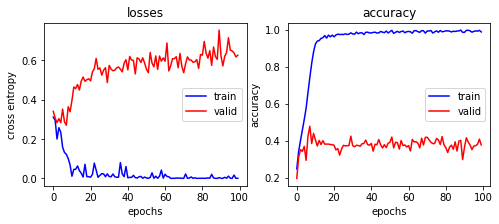

In [37]:
plt.figure(figsize=(8, 3))
ax1 = plt.subplot(121)
ax1.plot(h_epochs, h_train_losses_0, 'b', h_epochs, h_valid_losses_0, 'r')
ax1.set_title('losses')
ax1.set_ylabel('cross entropy')
ax1.set_xlabel('epochs')
ax1.legend(['train', 'valid'])
ax1 = plt.subplot(122)
ax1.plot(h_epochs, h_train_acc_0, 'b', h_epochs, h_valid_acc_0, 'r')
ax1.set_title('accuracy')
ax1.set_ylabel('accuracy')
ax1.set_xlabel('epochs')
ax1.legend(['train', 'valid'])
plt.show()

# Pix2Pix Check